In [1]:
pip install faker

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from faker import Faker
import random
import datetime

# Create a synthetic dataset
fake = Faker()

# Generate customer demographic data
n_samples = 1000
customer_data = {
    'CustomerID': [fake.uuid4() for _ in range(n_samples)],
    'Gender': [random.choice(['Male', 'Female']) for _ in range(n_samples)],
    'SeniorCitizen': [random.choice([0, 1]) for _ in range(n_samples)],
    'Partner': [random.choice(['Yes', 'No']) for _ in range(n_samples)],
    'Dependents': [random.choice(['Yes', 'No']) for _ in range(n_samples)],
    'Tenure': [random.randint(1, 72) for _ in range(n_samples)],
    'PhoneService': [random.choice(['Yes', 'No']) for _ in range(n_samples)],
    # Add other demographic columns here
}

# Generate service and usage data
service_data = {
    'CustomerID': customer_data['CustomerID'],
    'InternetService': [random.choice(['DSL', 'Fiber optic', 'No']) for _ in range(n_samples)],
    'MonthlyCharges': [random.uniform(20, 100) for _ in range(n_samples)],
    'TotalCharges': [random.uniform(100, 8000) for _ in range(n_samples)],
    # Add other service and usage columns here
}

# Generate transaction history
transaction_data = {
    'CustomerID': [random.choice(customer_data['CustomerID']) for _ in range(n_samples)],
    'TransactionID': [fake.uuid4() for _ in range(n_samples)],  # Assuming 1 transaction per customer
    'TransactionDate': [fake.date_between(start_date='-2y', end_date='today') for _ in range(n_samples)],
    'TransactionAmount': [random.uniform(10, 200) for _ in range(n_samples)],
    # Add other transaction-related columns here
}

# Generate customer interactions
interaction_data = {
    'CustomerID': [random.choice(customer_data['CustomerID']) for _ in range(n_samples)],
    'InteractionID': [fake.uuid4() for _ in range(n_samples)],  # Assuming 1 interaction per customer
    'InteractionDate': [fake.date_between(start_date='-2y', end_date='today') for _ in range(n_samples)],
    'InteractionType': [random.choice(['Phone call', 'Email', 'Chat']) for _ in range(n_samples)],
    # Add other interaction-related columns here
}

# Combine all data into a single DataFrame
customer_df = pd.DataFrame(customer_data)
service_df = pd.DataFrame(service_data)
transaction_df = pd.DataFrame(transaction_data)
interaction_df = pd.DataFrame(interaction_data)

# Merge the DataFrames using CustomerID
full_df = customer_df.merge(service_df, on='CustomerID').merge(transaction_df, on='CustomerID').merge(interaction_df, on='CustomerID')

# Ensure that there are no duplicate rows
full_df.drop_duplicates(subset=['CustomerID'], keep='first', inplace=True)

# Add a Churn column (simulated)
full_df['Churn'] = [random.choice(['Yes', 'No']) for _ in range(len(full_df))]

# Save the synthetic dataset to a CSV file
full_df.to_csv('synthetic_churn_dataset.csv', index=False)


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score

# Load your dataset (replace 'your_dataset.csv' with your data file)
data = pd.read_csv('synthetic_churn_dataset.csv')

# Data preprocessing
# Assuming 'Churn' is the target variable
X = data.drop('Churn', axis=1)
y = data['Churn']

# Handle missing values (you can customize this based on your data)
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X.fillna(0, inplace=True)

# Define categorical columns based on your dataset
categorical_cols = ['Gender', 'Partner', 'Dependents', 'PhoneService', 'InternetService', 'InteractionType']  # Update with your categorical columns

# Encoding categorical variables
label_encoders = {}
for col in categorical_cols:
    label_encoders[col] = LabelEncoder()
    X[col] = label_encoders[col].fit_transform(X[col])

# Exclude 'CustomerID' and other non-numeric columns from feature scaling
non_numeric_cols = ['CustomerID', 'TransactionID', 'TransactionDate', 'InteractionID', 'InteractionDate']  # Add any other non-numeric columns here
numeric_cols = [col for col in X.columns if col not in non_numeric_cols]
X = X[numeric_cols]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train a Random Forest Classifier (you can try other classifiers as well)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Map 'Yes' to 1 and 'No' to 0 in the target variable 'y'
y = y.map({'Yes': 1, 'No': 0})

# Map 'Yes' to 1 and 'No' to 0 in the predicted values for precision calculation
y_pred_mapped = [1 if label == 'Yes' else 0 for label in y_pred]

# Evaluate the model
accuracy = accuracy_score(y_test.map({'Yes': 1, 'No': 0}), y_pred_mapped)
precision = precision_score(y_test.map({'Yes': 1, 'No': 0}), y_pred_mapped)
recall = recall_score(y_test.map({'Yes': 1, 'No': 0}), y_pred_mapped)
roc_auc = roc_auc_score(y_test.map({'Yes': 1, 'No': 0}), clf.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')


Accuracy: 0.58
Precision: 0.55
Recall: 0.62
ROC AUC: 0.64


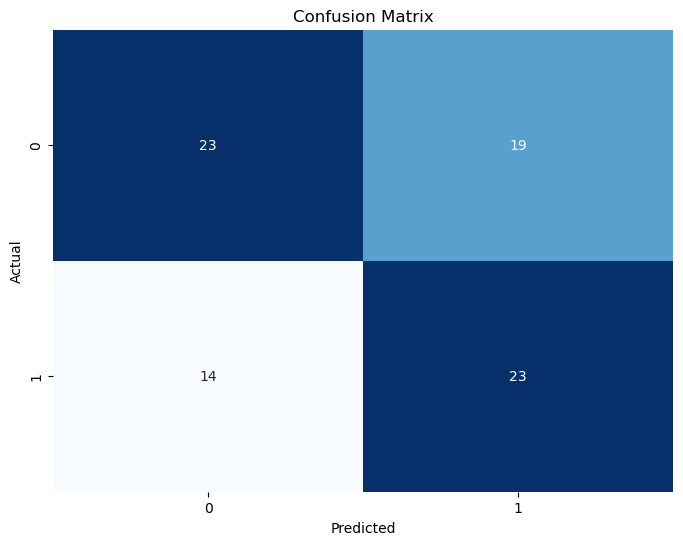

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
conf_matrix = confusion_matrix(y_test.map({'Yes': 1, 'No': 0}), y_pred_mapped)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




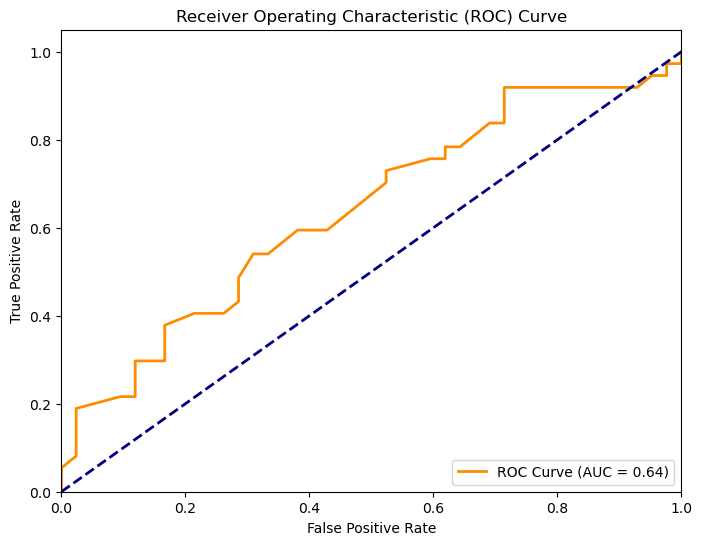

In [5]:
# ROC Curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc


# Train a Random Forest Classifier (you can try other classifiers as well)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions on the test set with probability estimates
y_prob = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test.map({'Yes': 1, 'No': 0}), y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [6]:
# Input your own data as a dictionary
new_data = {
    'Gender': ['Male'],
    'SeniorCitizen': [0],
    'Partner': ['Yes'],
    'Dependents': ['No'],
    'Tenure': [24],
    'PhoneService': ['Yes'],
    'InternetService': ['Fiber optic'],
    'MonthlyCharges': [85.0],
    'TotalCharges': [2040.0],
    'TransactionID': ['123456'],
    'TransactionDate': ['2023-08-25'],
    'TransactionAmount': [75.0],
    'InteractionID': ['789012'],
    'InteractionDate': ['2023-08-25'],
    'InteractionType': ['Email']
}

# Create a DataFrame from the input data
input_df = pd.DataFrame(new_data)

# Preprocess the input data (same preprocessing as your training data)
# Handle missing values, encode categorical variables, and scale numerical features

# Handle missing values (replace with 0 for simplicity)
input_df['TotalCharges'] = pd.to_numeric(input_df['TotalCharges'], errors='coerce')
input_df.fillna(0, inplace=True)

# Encoding categorical variables (using label encoders trained on your training data)
for col in categorical_cols:
    input_df[col] = label_encoders[col].transform(input_df[col])

# Exclude 'CustomerID' and other non-numeric columns from feature scaling
input_df = input_df[numeric_cols]

# Feature scaling (using the same scaler trained on your training data)
input_scaled = scaler.transform(input_df)

# Assuming you've loaded the trained Random Forest classifier as 'clf' earlier

# Use the trained model to make predictions
prediction = clf.predict(input_scaled)

# Map the prediction back to 'Yes' or 'No' for churn
if prediction[0] == 1:
    churn_status = 'Yes'
else:
    churn_status = 'No'

print(f'Predicted Churn Status: {churn_status}')


Predicted Churn Status: No
